In [46]:
from MEA_functions import *
from parameters_file import *

BEFORE STARTING

- Check if you put the images of the slices in the same folder as the h5 files 

To fill the excel file with the right information at the right place

In [47]:
%% cache
row = fill_info_file(return_row= True)
expand_ID(start = row)

UsageError: Cell magic `%%` not found.


To decide what we want to do 

In [48]:
%% cache
checkbox = ['interictal', 'MUA']
gui_dictionnary = make_choices(gui_dictionnary, text_keys = [], checkbox_keys = checkbox)
peak_types = [key for key in checkbox if int(gui_dictionnary[key]['value'])]
gui_dictionnary = make_choices(gui_dictionnary, text_keys = ['channels'], checkbox_keys = [])
channels = gui_dictionnary['channels']['value'].replace(' ', '').split(',')

UsageError: Cell magic `%%` not found.


In [49]:
peak_types =  ['interictal', 'MUA']
paths, channels_to_keep_by_path = paths_channels_from_info()

We need to manually apply the right layout to get the position of the channels in respect to the image

In [50]:
%% cache
paths = choose_files_from_info()
for path in paths :
    # Call function to extract signal and channel names from the h5 file 
    date_time = date_time_from_path(path) 
    %matplotlib qt
    show_image_tag_channels(date_time, list_channels_all)


UsageError: Cell magic `%%` not found.


Next the signal is preprocessed and the peaks are found (long). The peaks are saved in the 'peaks' file 

In [51]:
%% cache 
paths, _ = paths_channels_from_info()
#paths = choose_files_from_info()

for num_path, path in enumerate(paths):

    # Call function to extract signal and channel names from the h5 file 
    date_time = date_time_from_path(path)
    raw, channels = raw_signals_from_file(path)
    
    # channels_to_keep = channels_to_keep_by_path[path]
    # if channels_to_keep != ['all'] : 
    #     channels = [channel for channel in channels_to_keep if channel in channels]

    for num_channel, channel in enumerate(channels) :
        
        channel_index = channels.index(channel)
        # Take only the signal from the channel chosen
        raw_channel = raw[channel_index]

        # Call the class preprocessing to filter, (denoise) and normalize the signal 
        data = preprocessing(raw_channel, peak_types)

        # Call the class find_events to find the peaks for each defined peak type 
        peaks = find_events(data)

        # To save to excel (time consuming) 
        # save_events(date_time, channel, data, peaks)

        # To save to a pickle object 
        save_dict(peaks, f'{peaks_folder}_{date_time}_{channel}.pkl')

        print(f'{date_time}, {channel} ({len(peaks.frame_index["interictal"])} IILD / {len(peaks.frame_index["MUA"])} MUA).. {int(100*(num_channel+1)/len(channels))}% done for path {num_path+1} out of {len(paths)}', end = '\r')

UsageError: Cell magic `%%` not found.


Need to manually check if the peaks are okay for each path 

In [52]:
%% cache 
paths, _ = paths_channels_from_info()
min_freq = {'MUA' : 0.025, 'MUA' : 0.25}

%matplotlib qt 
for path in paths :
    date_time = date_time_from_path(path)
    list_files = list_date_time_pkl(date_time)
    for file in list_files:
        channel = channel_from_pkl(date_time, file)
        peaks = read_dict(f'{peaks_folder}_{date_time}_{channel}.pkl')
        redo = False
        if freqs*len(peaks.frame_index['interictal'])/peaks.total_frames > min_freq['interictal'] : 
            redo = True 
        if redo :
            peaks, deleted = select_peaks(path, channel, peak_types, peaks = peaks, x_window = 500)
            rewrite_peaks_pkl(date_time, channel, peaks, deleted) 
        if redo == True :
            print('Continue ? write anything for yes and no for stop')
            resp = input()
        else : 
            resp = ''
        if resp == 'no' :
            break
    if resp == 'no' : 
        break

UsageError: Cell magic `%%` not found.


To write the results in a result file 

In [53]:
%% cache
paths, _ = paths_channels_from_info()
#for path in paths :
for p,path in enumerate(paths) :
    date_time = date_time_from_path(path)
    for peak_type in peak_types :
        write_raw_results_file(date_time, peak_type, min_freq[peak_type])
    print(f'done for {100*p/len(paths)}%', end = '\r')

UsageError: Cell magic `%%` not found.


To summerize the results in a dictionnary 

In [54]:
%% cache
y_all= {}
for drug in ['terbinafine', 'terbinafine_100', 'NPBA_10', 'NPBA_20'] :
    conditions = 'baseline', drug, 'washout'
    check = {'criteria': drug, 'category' : 'Condition', 'condition': drug}
    y_all[drug] = {}
    for peak_type in peak_types :
        y_all[drug][peak_type] = y_from_exp_ID(check, peak_type, excel = False) 

save_dict(y_all, f'{folder_fig}/y_data.pkl')

UsageError: Cell magic `%%` not found.


To read the dictionnary if already created

To make all the important plots

In [55]:
%% cache
y_all= {}
for drug in ['terbinafine', 'terbinafine_100', 'NPBA_10', 'NPBA_20'] :
    conditions = 'baseline', drug, 'washout'
    check = {'criteria': drug, 'category' : 'Condition', 'condition': drug}
    y_all[drug] = {}
    freq, amp, power, channels_interictal = y_from_exp_ID(check, 'interictal', channels_to_use = 'best_baseline', return_channels = True) 
    y_all[drug]['interictal'] = freq, amp
    y_all[drug]['MUA'] = y_from_exp_ID(check, 'MUA', channels_to_use = channels_interictal) 

save_dict(y_all, f'{folder_fig}/y_interictal_based.pkl')

UsageError: Cell magic `%%` not found.


In [56]:
%% cache
y_all= {}
for drug in ['terbinafine', 'terbinafine_100', 'NPBA_10', 'NPBA_20'] :
    conditions = 'baseline', drug, 'washout'
    check = {'criteria': drug, 'category' : 'Condition', 'condition': drug}
    y_all[drug] = {}
    for peak_type in peak_types :
        y_all[drug][peak_type], channels = freq_all_from_exp_ID(check, peak_type, excel = False, return_channels=True) 

save_dict(y_all, f'{folder_fig}/y_freq_time.pkl')

UsageError: Cell magic `%%` not found.


In [57]:
proportion_slices_IILDs = {'SH-2022-002' : {'yes':[5,6,7,9], 'no' : [3,4,8]}, 'SH-2022-004' : {'yes' : [5,7,8], 'no' : [1,2,3,4,6,9,10]}, 'SH-2022-005' : {'yes' : [2,3,5,6], 'no' : [1,4,7,8,9,10]}, 'SH-2023-000' : {'yes' : [2,3], 'no' : [1,4]}, 'SH-2023-001' : {'yes': [3,4,5,6,8,9], 'no' : [10,7]}}

percentage_IILDs = []

for exp in proportion_slices_IILDs.keys() :
    percentage_IILDs.append(len(proportion_slices_IILDs[exp]['yes'])/(len(proportion_slices_IILDs[exp]['yes'])+len(proportion_slices_IILDs[exp]['no'])))

print(f'% slices with IILDs. Median : {np.nanmedian(percentage_IILDs)}. Std : {np.nanstd(percentage_IILDs)}, Mean: {np.nanmean(percentage_IILDs)}, SEM: {sem(percentage_IILDs)}')


% slices with IILDs. Median : 0.5. Std : 0.15330375343195785, Mean: 0.5042857142857142, SEM: 0.07665187671597892


interictal - terbinafine - 6 trials
0 1 0.36543685019693883 ttest
terbinafine_interictal_Frequency (Hz) - baseline. Median : 0.03333333333333334. Std : 0.0504779998677396, Mean: 0.04801587301587302, SEM: 0.022574447814498227
terbinafine_interictal_Frequency (Hz) - terbinafine. Median : 0.02142857142857143. Std : 0.017260764421374246, Mean: 0.025396825396825393, SEM: 0.0077192485179605275
0 1 0.07345871019752992 ttest
terbinafine_interictal_Amplitude (µV) - baseline. Median : 24.587062500000002. Std : 8.136531662948912, Mean: 23.760043125, SEM: 3.638767579886635
terbinafine_interictal_Amplitude (µV) - terbinafine. Median : 11.28024625. Std : 6.524607598844014, Mean: 14.434344166666664, SEM: 2.917893223505379
interictal - NPBA_10 - 3 trials
0 1 0.037829107887670584 ttest
NPBA_10_interictal_Frequency (Hz) - baseline. Median : 0.06190476190476191. Std : 0.022419756971151637, Mean: 0.07142857142857144, SEM: 0.015853162186855698
NPBA_10_interictal_Frequency (Hz) - NPBA_10. Median : 0.0095238

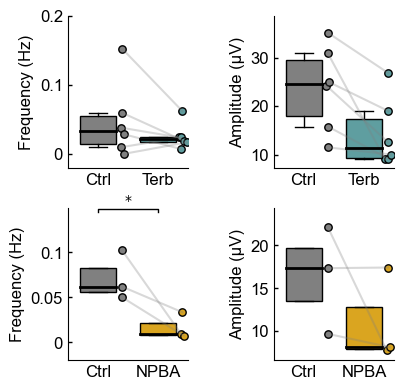

MUA - terbinafine - 6 trials
0 1 0.03125 wilcoxon
terbinafine_MUA_Frequency (Hz) - baseline. Median : 0.8083333333333333. Std : 0.7451549432116746, Mean: 0.998015873015873, SEM: 0.33324342135826
terbinafine_MUA_Frequency (Hz) - terbinafine. Median : 0.19166666666666668. Std : 0.29748886041505934, Mean: 0.2738095238095238, SEM: 0.1330410628874038
baseline and terbinafine, p = 0.03125   (wilcoxon)
0 1 0.5885146745858358 ttest
terbinafine_MUA_Amplitude (µV) - baseline. Median : 14.431860624999999. Std : 5.558949653422279, Mean: 15.492332916666667, SEM: 2.486037861710223
terbinafine_MUA_Amplitude (µV) - terbinafine. Median : 13.351519999999999. Std : 3.608151865799552, Mean: 13.835810625, SEM: 1.6136145690140995
MUA - NPBA_10 - 3 trials
0 1 0.5144043823358457 ttest
NPBA_10_MUA_Frequency (Hz) - baseline. Median : 2.0. Std : 0.9372495046212745, Mean: 2.422222222222222, SEM: 0.6627354803814356
NPBA_10_MUA_Frequency (Hz) - NPBA_10. Median : 1.3166666666666667. Std : 1.0980416154530837, Mean: 1

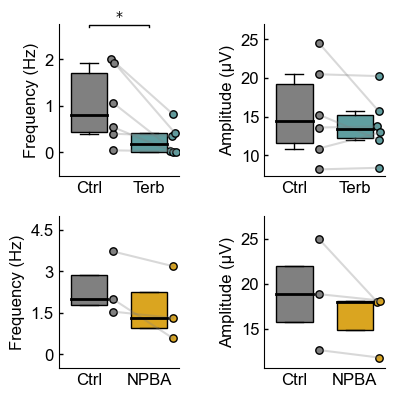

In [58]:
#%% cache
y_all = read_dict(f'{folder_fig}/y_data.pkl')
%matplotlib inline

drugs = ['terbinafine', 'terbinafine_100', 'NPBA_10']

limy = {}
broken = {}
yticks =  {}
for peak_type in peak_types :
    limy[peak_type] = {}
    broken[peak_type] = {}
    yticks[peak_type] = {}
    for drug in drugs :
        limy[peak_type][drug] = [None for _ in range (3)]
        broken[peak_type][drug] = [None for _ in range (3)]
        yticks[peak_type][drug] = [None for _ in range (3)]

# frequency
limy['interictal']['terbinafine'][0] = [-0.02,0.2]
yticks['interictal']['terbinafine'][0] = [0,0.1,0.2]
limy['interictal']['NPBA_10'][0] = [-0.02,0.12]
yticks['interictal']['NPBA_10'][0] = [0,0.05,0.1]

limy['MUA']['terbinafine'][0] = [-0.5,2.2]
yticks['MUA']['terbinafine'][0] = [0,1,2]
limy['MUA']['NPBA_10'][0] = [-0.5,5]
yticks['MUA']['NPBA_10'][0] = [0,1.5,3,4.5]

# amplitude
yticks['interictal']['terbinafine'][1] = [10,20,30]
yticks['interictal']['NPBA_10'][1] = [10,15,20]

yticks['MUA']['terbinafine'][1] = [10,15,20,25]
yticks['MUA']['NPBA_10'][1] = [15,20,25]


drug_short = ['Terb', 'NPBA']
for peak_type in peak_types :   
    fig, axes = start_fig(nrows = 2, ncols = 2)
    for d,drug in enumerate(['terbinafine', 'NPBA_10']) :
        conditions = 'baseline', drug, 'washout'
        check = {'criteria': drug, 'category' : 'Condition', 'condition': drug}
        xticks = [['Ctrl', drug_short[d]] for _ in range (3)]
        axes[d] = final_plotting(y_all[drug][peak_type][:2], conditions, check,  peak_type, normalize_to_baseline = False, limy = limy[peak_type][drug], time_limit = False, saving = False, timeplot = False, no_washout = True, subplots= True, fig = fig, axes = axes[d], broken = broken[peak_type][drug], yticks = yticks[peak_type][drug], xticks = xticks)
    
    plt.savefig(f'{folder_fig}\\boxplot_{peak_type}.png', format = 'png', transparent = True, bbox_inches='tight')
    plt.show()

In [104]:
y_all = read_dict(f'{folder_fig}/y_data.pkl')
baseline_freq ={}
baseline_amp ={}
for peak_type in peak_types :   
    baseline_freq[peak_type] = []
    baseline_amp[peak_type] = []
    for d,drug in enumerate(['terbinafine', 'NPBA_10']) :
        for i in range (len(y_all[drug][peak_type][0])) :
            baseline_freq[peak_type].append(y_all[drug][peak_type][0][i][0])
            baseline_amp[peak_type].append(y_all[drug][peak_type][1][i][0])

    print(f' Freq {peak_type} - n = {len(baseline_freq[peak_type])} Median : {np.nanmedian(baseline_freq[peak_type])}. Std : {np.nanstd(baseline_freq[peak_type])}, Mean: {np.nanmean(baseline_freq[peak_type])}, SEM: {sem(baseline_freq[peak_type])}')
    print(f' Amp {peak_type} - n = {len(baseline_amp[peak_type])} Median : {np.nanmedian(baseline_amp[peak_type])}. Std : {np.nanstd(baseline_amp[peak_type])}, Mean: {np.nanmean(baseline_amp[peak_type])}, SEM: {sem(baseline_amp[peak_type])}')


 Freq interictal - n = 9 Median : 0.05. Std : 0.04458751223499139, Mean: 0.05582010582010583, SEM: 0.015764066128800283
 Amp interictal - n = 9 Median : 22.113455. Std : 8.0611584900228, Mean: 21.29885333333333, SEM: 2.8500499162573156
 Freq MUA - n = 9 Median : 1.545238095238095. Std : 1.0553342118513185, Mean: 1.4727513227513227, SEM: 0.3731169888091139
 Amp MUA - n = 9 Median : 15.27378125. Std : 5.6197162200882484, Mean: 16.601648194444444, SEM: 1.9868697237842163


0.8083333333333333

interictal - terbinafine - 6 trials
0 1 0.36543685019693883 ttest
0 2 0.5287030939659566 ttest
1 2 0.7581521148564676 ttest
terbinafine_interictal_Frequency (Hz) - baseline. Median : 0.03333333333333334. Std : 0.0504779998677396, Mean: 0.04801587301587302, SEM: 0.022574447814498227
terbinafine_interictal_Frequency (Hz) - terbinafine. Median : 0.02142857142857143. Std : 0.017260764421374246, Mean: 0.025396825396825393, SEM: 0.0077192485179605275
terbinafine_interictal_Frequency (Hz) - washout. Median : 0.017857142857142856. Std : 0.032103640587588696, Mean: 0.030555555555555555, SEM: 0.014357184535813925
0 1 0.07345871019752992 ttest
0 2 0.7730864307867248 ttest
1 2 0.40274566177310966 ttest
terbinafine_interictal_Amplitude (µV) - baseline. Median : 24.587062500000002. Std : 8.136531662948912, Mean: 23.760043125, SEM: 3.638767579886635
terbinafine_interictal_Amplitude (µV) - terbinafine. Median : 11.28024625. Std : 6.524607598844014, Mean: 14.434344166666664, SEM: 2.917893223505379
terb

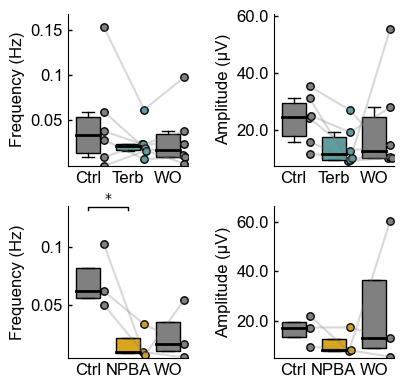

MUA - terbinafine - 6 trials
0 1 0.03125 wilcoxon
0 2 0.7657822718274163 ttest
1 2 0.21875 wilcoxon
terbinafine_MUA_Frequency (Hz) - baseline. Median : 0.8083333333333333. Std : 0.7451549432116746, Mean: 0.998015873015873, SEM: 0.33324342135826
terbinafine_MUA_Frequency (Hz) - terbinafine. Median : 0.19166666666666668. Std : 0.29748886041505934, Mean: 0.2738095238095238, SEM: 0.1330410628874038
terbinafine_MUA_Frequency (Hz) - washout. Median : 0.09523809523809523. Std : 1.1646026986505775, Mean: 0.8087301587301586, SEM: 0.5208261601924787
baseline and terbinafine, p = 0.03125   (wilcoxon)
0 1 0.5885146745858358 ttest
0 2 0.5004990783456013 ttest
1 2 0.8878309688831965 ttest
terbinafine_MUA_Amplitude (µV) - baseline. Median : 14.431860624999999. Std : 5.558949653422279, Mean: 15.492332916666667, SEM: 2.486037861710223
terbinafine_MUA_Amplitude (µV) - terbinafine. Median : 13.351519999999999. Std : 3.608151865799552, Mean: 13.835810625, SEM: 1.6136145690140995
terbinafine_MUA_Amplitude 

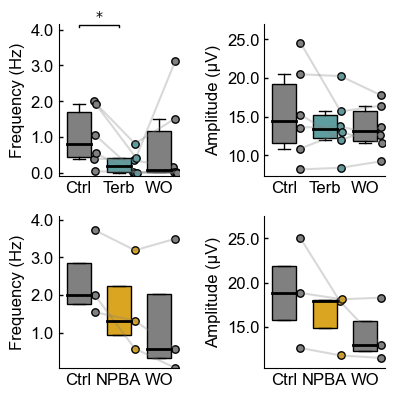

In [59]:
#%% cache
y_all = read_dict(f'{folder_fig}/y_data.pkl')
%matplotlib inline

drugs = ['terbinafine', 'terbinafine_100', 'NPBA_10']

limy = {}
broken = {}
yticks =  {}
for peak_type in peak_types :
    limy[peak_type] = {}
    broken[peak_type] = {}
    yticks[peak_type] = {}
    for drug in drugs :
        limy[peak_type][drug] = [None for _ in range (3)]
        broken[peak_type][drug] = [None for _ in range (3)]
        yticks[peak_type][drug] = [None for _ in range (3)]

for drug in drugs :
    yticks['interictal'][drug] = [[0.05,0.10,0.15], None, None]

drug_short = ['Terb', 'NPBA']
for peak_type in peak_types :   
    fig, axes = start_fig(nrows = 2, ncols = 2)
    for d,drug in enumerate(['terbinafine', 'NPBA_10']) :
        conditions = 'baseline', drug, 'washout'
        check = {'criteria': drug, 'category' : 'Condition', 'condition': drug}
        xticks = [['Ctrl', drug_short[d], 'WO'] for _ in range (3)]
        axes[d] = final_plotting(y_all[drug][peak_type][:2], conditions, check,  peak_type, normalize_to_baseline = False, limy = limy[peak_type][drug], time_limit = False, saving = False, timeplot = False, no_washout = False, subplots= True, fig = fig, axes = axes[d], broken = broken[peak_type][drug], yticks = yticks[peak_type][drug], xticks = xticks)
    
    plt.savefig(f'{folder_fig}\\boxplot_with_washout_{peak_type}.png', format = 'png', transparent = True, bbox_inches='tight')
    plt.show()

In [60]:
%% cache 

%matplotlib inline
time_window = {'interictal' : 10*freqs, 'MUA' : 10*freqs}
n = {'interictal' : 3, 'MUA' : 2}
paths = [r'W:\Analysis\MEA\task3\\2022-11-22\2022-11-22T16-59-14McsRecording.h5', r'W:\Analysis\MEA\task3\\2022-11-22\2022-11-22T17-16-27McsRecording.h5', r'W:\Analysis\MEA\task3\2022-07-26\2022-07-26T15-22-57McsRecording.h5', r'W:\Analysis\MEA\task3\2022-07-26\2022-07-26T15-34-34McsRecording.h5']
channels = ['K5', 'K5', 'E6', 'E6']
frames_10s  = [[799570, 899570], [955647, 1055647], [5432540, 5532540], [3272525, 3372525]]


for path, channel, frames in zip(paths, channels, frames_10s) :
    print(f'{path}: channel {channel}, from {frames[0]} to {frames[1]}')
    plot_raw_signal(path, channel, frames, raster_plot = True,  peak_types = peak_types, saving=True, format_fig='png', limy=[-25,25], xbar = 2*freqs, ybar = 20)


UsageError: Cell magic `%%` not found.


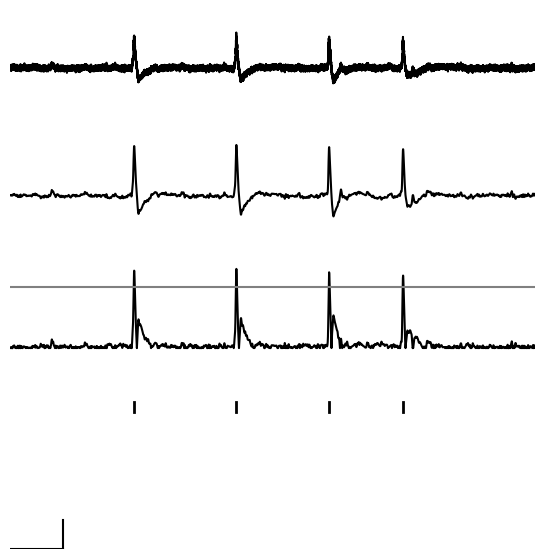

In [61]:
peak_type = 'interictal'
path = r'W:\Analysis\MEA\task3\2023_04_06\2023-04-06T17-56-57McsRecording.h5'
channel = 'F5'
frames = [28*freqs, 38*freqs]
plot_frames_data_type(path, channel, peak_type, frames, raster_plot= True, draw_line=True, color='black', saving=True, format_fig='png', xbar = freqs, ybar = 100)

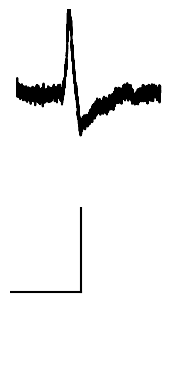

In [62]:
frames = [30*freqs, 31*freqs]
plot_raw_signal(path, channel, frames, raster_plot = False,  peak_types = peak_types, saving=True, format_fig='png', limy=[-100,100], xbar = 0.5*freqs, ybar = 100)

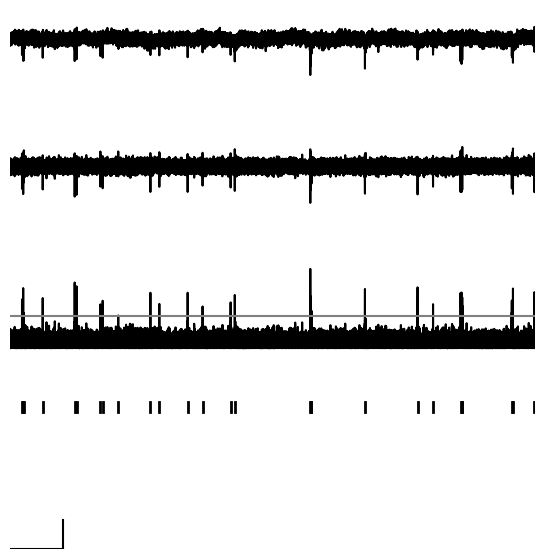

In [63]:
peak_type = 'MUA'
path = r'W:\Analysis\MEA\task3\2023-04-25\2023-04-25T18-11-01McsRecording.h5'
channel = 'D3'
frames = [(3*60+4)*freqs, (3*60+14)*freqs]
plot_frames_data_type(path, channel, peak_type, frames, raster_plot= True, draw_line=True, color='black', saving = True, xbar = freqs, ybar = 50, format_fig='png')

In [64]:
%% cache 

y_all= {}
for drug in ['terbinafine', 'terbinafine_100', 'NPBA_10', 'NPBA_20'] :
    conditions = 'baseline', drug, 'washout'
    check = {'criteria': drug, 'category' : 'Condition', 'condition': drug}
    y_all[drug] = {}
    for peak_type in peak_types :
        y_all[drug][peak_type] = surf_from_exp_ID(check, peak_type, excel = False) 

save_dict(y_all, f'{folder_fig}/y_surf.pkl')

UsageError: Cell magic `%%` not found.


interictal - terbinafine - 6 trials
0 1 0.3171633626341051 ttest
terbinafine_interictal_Area (mm²) - baseline. Median : 2.25. Std : 3.2882366094914763, Mean: 3.25, SEM: 1.4705441169852742
terbinafine_interictal_Area (mm²) - terbinafine. Median : 0.75. Std : 1.7320508075688772, Mean: 1.5, SEM: 0.7745966692414834
interictal - NPBA_10 - 3 trials
0 1 0.17971249487899976 wilcoxon
NPBA_10_interictal_Area (mm²) - baseline. Median : 6.0. Std : 31.13679495388053, Mean: 26.5, SEM: 22.017038856303998
NPBA_10_interictal_Area (mm²) - NPBA_10. Median : 3.0. Std : 0.7071067811865476, Mean: 3.5, SEM: 0.5


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


MUA - terbinafine - 6 trials
0 1 0.4413143004514446 ttest
terbinafine_MUA_Area (mm²) - baseline. Median : 6.0. Std : 2.23606797749979, Mean: 5.5, SEM: 1.0
terbinafine_MUA_Area (mm²) - terbinafine. Median : 3.0. Std : 3.5355339059327378, Mean: 4.0, SEM: 1.5811388300841898
MUA - NPBA_10 - 3 trials
0 1 0.75 wilcoxon
NPBA_10_MUA_Area (mm²) - baseline. Median : 12.0. Std : 27.937430089397985, Mean: 31.0, SEM: 19.75474626513841
NPBA_10_MUA_Area (mm²) - NPBA_10. Median : 10.5. Std : 1.224744871391589, Mean: 10.5, SEM: 0.8660254037844387


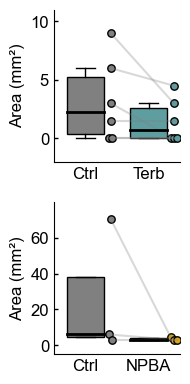

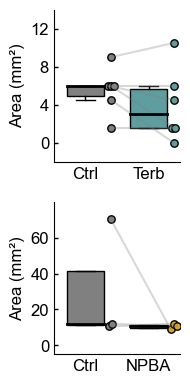

In [65]:
#%% cache
limy = {}
broken = {}
yticks =  {}
for peak_type in peak_types :
    limy[peak_type] = {}
    broken[peak_type] = {}
    yticks[peak_type] = {}
    for drug in ['terbinafine', 'NPBA_10'] :
        limy[peak_type][drug] = [None]
        broken[peak_type][drug] = [None]
        yticks[peak_type][drug] = [None]

limy['interictal']['terbinafine'][0] = [-2,11]
yticks['interictal']['terbinafine'][0] = [0,5,10]
limy['interictal']['NPBA_10'][0] = [-5,80]
yticks['interictal']['NPBA_10'][0] = [0,20,40,60]

limy['MUA']['terbinafine'][0] = [-2,14]
yticks['MUA']['terbinafine'][0] = [0,4,8,12]
limy['MUA']['NPBA_10'][0] = [-5,80]
yticks['MUA']['NPBA_10'][0] = [0,20,40,60]

peak_short = {'interictal' : 'IILDs', 'MUA' : 'MUA'}
drug_short = ['Terb', 'NPBA']

y_all= read_dict(f'{folder_fig}/y_surf.pkl')
for peak_type in peak_types :
    fig, axes = start_fig(nrows = 2, ncols = 1)
    for d,drug in enumerate(['terbinafine', 'NPBA_10']) :
        conditions = 'baseline', drug, 'washout'
        check = {'criteria': drug, 'category' : 'Condition', 'condition': drug}
        xticks = [['Ctrl', drug_short[d]] for _ in range (3)]
        axes[d] = final_plotting([y_all[drug][peak_type]], conditions, check,  peak_type, names = [f'Area (mm²)'], normalize_to_baseline = False, limy = limy[peak_type][drug], time_limit = False, saving = False, timeplot = False, no_washout = True, subplots= True, fig = fig, axes = [axes[d]], broken = broken[peak_type][drug], yticks = yticks[peak_type][drug], xticks = xticks)
    
        plt.savefig(f'{folder_fig}\\surface_{peak_type}.png', format = 'png', transparent = True, bbox_inches='tight')
    


Other interesting plots

In [66]:
%% cache 

%matplotlib inline
paths = [r'W:\Analysis\MEA\task3\\2022-11-22\2022-11-22T19-49-24McsRecording.h5', r'W:\Analysis\MEA\task3\\2022-11-22\2022-11-22T20-05-08McsRecording.h5', r'W:\Analysis\MEA\task3\2022-07-26\2022-07-26T15-22-57McsRecording.h5', r'W:\Analysis\MEA\task3\2022-07-26\2022-07-26T15-34-34McsRecording.h5']
limits = [[0,0.45],[0,4.5]], [[0,0.45],[0,4.5]], [[0.05,0.25],[0,3.5]], [[0.05,0.25],[0,3.5]]
yticks = [[0.1,0.2,0.3,0.4], [1,2,3,4]], [[0.1,0.2,0.3,0.4], [1,2,3,4]], [[0.1,0.15,0.2], [1,2,3]],[[0.1,0.15,0.2], [1,2,3]]
#paths = choose_files_from_info()
for path, limit, ytick in zip(paths,limits, yticks) :
    date_time = date_time_from_path(path)
    print(date_time)
    show_colormap_2Z(date_time, peak_criteria='frequency', peak_types = ['interictal','MUA'], saving = True, ylims = limit, yticks = ytick, format_save = 'png')


UsageError: Cell magic `%%` not found.


c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


F2 : (1106.475556089479, 537.2485805333902), z = (0.09047619047619047, 3.3380952380952382)
C3 : (221.234215151936, 743.877394757141), z = (0.1, 4.309523809523809)
D3 : (518.1271955892203, 740.6148345325555), z = (0.10476190476190476, 0.023809523809523808)
E3 : (815.0201760265045, 737.35227430797), z = (0.05238095238095238, 0.9285714285714286)
F3 : (1111.913156463789, 734.0897140833845), z = (0.08571428571428572, 0.5190476190476191)
C4 : (226.6718155262456, 940.7185283071353), z = (0.0380952380952381, 1.2476190476190476)
E4 : (820.457776400814, 934.1934078579643), z = (0.12380952380952381, 5.1571428571428575)
C5 : (232.1094159005552, 1137.55966185713), z = (0.0380952380952381, 0.1380952380952381)
E5 : (825.8953767751236, 1131.034541407959), z = (0.08571428571428572, 4.852380952380952)
F5 : (1122.788357212408, 1127.771981183373), z = (0.08571428571428572, 4.480952380952381)
G5 : (1419.681337649692, 1124.509420958788), z = (0.06666666666666667, 0.9238095238095239)
H5 : (1716.574318086976,

w:\Analysis\MEA\code_python\MEA_functions.py:2514: UserWarning: The following kwargs were not used by contour: 'algorithm'
  cb1 = ax.contourf(Xg, Yg, Z1, cmap= mapcolor1, levels = levels1, antialiased=True, vmin = min_z1, vmax =max_z1,  algorithm = 'serial')
w:\Analysis\MEA\code_python\MEA_functions.py:2518: UserWarning: The following kwargs were not used by contour: 'algorithm'
  cb2 = ax.contourf(Xg, Yg, Z2, cmap= mapcolor2, levels = levels2, antialiased=True,  vmin = min_z2, vmax =max_z2, algorithm = 'serial')


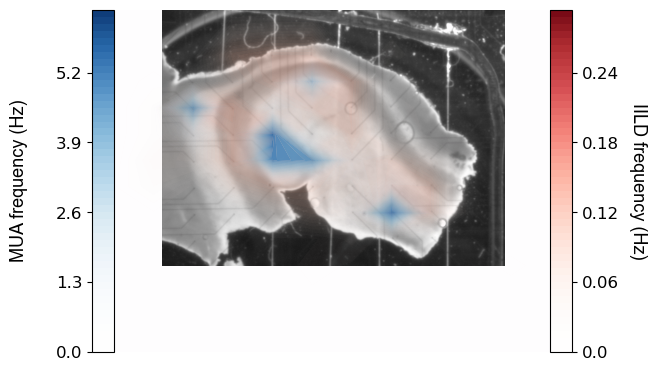

In [67]:
path = r'W:\Analysis\MEA\task3\2023_04_06\2023-04-06T19-40-16McsRecording.h5'
date_time = date_time_from_path(path)
show_colormap_2Z(date_time, peak_criteria='frequency', peak_types = ['interictal','MUA'], saving = True, format_save = 'png', ylims = [[0,0.3], [0,6.5]])


c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


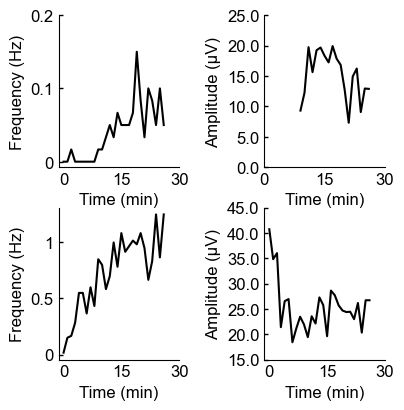

In [68]:
path = r'W:\Analysis\MEA\task3\2022-07-26\2022-07-26T17-20-16McsRecording.h5'

evols = [time_evol(path, 'G6', 'interictal'), time_evol(path, 'J4', 'MUA')]

f, ax = start_fig(ncols = 2, nrows = 2)


ylabels = ['Frequency (Hz)', 'Amplitude (µV)'] 

yticks = [[0,0.1,0.2],None], [[0,0.5,1],None]
for i in range (len((evols))) :
    for j in range (len(evols[i])) : 
        ax[i][j].plot(evols[i][j], color = 'black')
        ax[i][j] = set_ax_parameters(ax[i][j], show_xticks=True, xticks = [0,15,30], xlabel='Time (min)', yticks = yticks[i][j], ylabel = ylabels[j])

plt.savefig(f'{folder_fig}\\time_evol.png', format = 'png', transparent = True, bbox_inches='tight')
plt.show()
